# This is a demo for generating CBC chirp signals using LAL

First, start by importing necessary modules

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lal

from __future__ import division

import sys
import math

import numpy

import matplotlib
import matplotlib.pyplot as plot

import lal
from lal import CachedDetectors
from lal import LALDetectorIndexLHODIFF,LALDetectorIndexLLODIFF,LALDetectorIndexVIRGODIFF

from lal import LIGOTimeGPS
from lal import MSUN_SI as LAL_MSUN_SI
from lal import PC_SI as LAL_PC_SI
from lal import DictInsertREAL8Value, DictInsertINT4Value

import lalsimulation
from _lalsimulation import SimInspiralTD
from _lalsimulation import SimInspiralCreateWaveformFlags
from _lalsimulation import GetApproximantFromString
from _lalsimulation import SimInspiralWaveformParamsInsertTidalLambda1
from _lalsimulation import SimInspiralWaveformParamsInsertTidalLambda2

from lal import ComputeDetAMResponse

DETECTOR_SITES = {
    'H1': LALDetectorIndexLHODIFF,
    'L1': LALDetectorIndexLLODIFF,
    'V1': LALDetectorIndexVIRGODIFF
    }

ZERO = {'x': 0., 'y': 0., 'z': 0.}

# map order integer to a string that can be parsed by lalsimulation
PN_ORDERS = {
    'default'          : -1,
    'zeroPN'           : 0,
    'onePN'            : 2,
    'onePointFivePN'   : 3,
    'twoPN'            : 4,
    'twoPointFivePN'   : 5,
    'threePN'          : 6,
    'threePointFivePN' : 7,
    'pseudoFourPN'     : 8,
    }


In [59]:
class Binary(object):
    """
    A CompactBinary object characterises a binary formed by two compact objects.
    """

    def __init__(self, mass1=1.4, mass2=1.4, distance=1, \
                 spin1=ZERO, spin2=ZERO, lambda1=0, lambda2=0, 
                 eccentricity=0, meanPerAno=0, 
                 inclination=0, psi=0):
        """
        mass1, mass2 -- masses of the binary components in solar masses
        distance -- distance of the binary in Mpc
        redshift -- redshift of the binary. If zero, cosmology is ignored.
        spin1, spin2 -- spin vectors of binary components
        lambda1,lambda2 -- tidal parameters
        eccentricity -- eccentricity at reference epoch
        meanPerAno -- mean anomaly of periastron
        inclination -- inclination angle with respect to the line of sight in degrees
        psi -- longitude of ascending nodes, degenerate with the polarization angle (Omega or psi)
        """
        self.mass1 = mass1
        self.mass2 = mass2
        self.distance = distance
        self.spin1 = spin1
        self.spin2 = spin2
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.eccentricity = eccentricity
        self.meanPerAno = meanPerAno 
        self.iota = inclination
        self.longAscNodes = psi

In [60]:
class Template(object):
    """
    A Template object characterises the gravitational
    wave (GW) chirp signal associated to the coalescence of two
    inspiralling compact objects.
    """

    def __init__(self, approximant, amplitude0, phase0, sampling_rate, segment_duration, freq_min, freq_max, freq_ref, phi_ref, nonGRparams):
        """
        approximant -- model approximant
        amplitude0  -- amplitude pN order: -1 means include all
        phase0      -- phase pN order: -1 means include all
        sampling_rate    -- sampling rate in Hz
        segment_duration -- segment duration in sec
        freq_min -- start frequency in Hz
        freq_max -- end frequency in Hz
        freq_ref -- reference frequency for precessing spins in Hz
        phi_ref  -- final phase in degrees
        nonGRparams -- non GR parameters
        """
        
        self.approximant = GetApproximantFromString(approximant)
        self.sampling_rate = sampling_rate # Hz
        self.segment_duration = segment_duration # sec
        self.amplitude0 = amplitude0
        self.phase0 = phase0
        self.freq_min = freq_min # Hz, start frequency
        self.freq_max = freq_max # Hz, end frequency
        self.freq_ref = freq_ref # Hz, reference frequency for precessing spins
        self.phi_ref  = phi_ref  # final phase in degrees
        self.nonGRparams = nonGRparams # non GR parameters
        self.waveform_flags = SimInspiralCreateWaveformFlags()
        
    def time_domain(self, binary):
        """
        Compute time-domain template model of the gravitational wave for a given compact binary.
        Ref: http://software.ligo.org/docs/lalsuite/lalsimulation/group__lalsimulation__inspiral.html
        """
         # build structure containing variable with default values
        extra_params = lal.CreateDict()
        DictInsertREAL8Value(extra_params,"Lambda1", binary.lambda1)
        SimInspiralWaveformParamsInsertTidalLambda1(extra_params, binary.lambda1)
        DictInsertREAL8Value(extra_params,"Lambda2", binary.lambda2)
        SimInspiralWaveformParamsInsertTidalLambda2(extra_params, binary.lambda2)
        DictInsertINT4Value(extra_params, "amplitude0", self.amplitude0)
        DictInsertINT4Value(extra_params, "phase0", self.phase0)
        
    
        return SimInspiralTD(binary.mass1 * LAL_MSUN_SI, binary.mass2 * LAL_MSUN_SI, \
                             binary.spin1['x'], binary.spin1['y'], binary.spin1['z'], \
                             binary.spin2['x'], binary.spin2['y'], binary.spin2['z'], \
                             binary.distance * 1.0e6 * LAL_PC_SI, math.radians(binary.iota), \
                             math.radians(self.phi_ref), math.radians(binary.longAscNodes), \
                             binary.eccentricity, binary.meanPerAno, \
                             1.0 / self.sampling_rate, self.freq_min, self.freq_ref, \
                             extra_params, self.approximant)

In [61]:
class Detector(object):
    """
    A Detector object characterises a gravitational wave (GW) interferometric detector
    """

    def __init__(self, detector):
        """
        detector  -- label string of the detector
        descriptor -- LAL descriptor
        location -- geographic location of the detector
        response -- response matrix

        """
        self.name = detector
        self.descriptor =  CachedDetectors[DETECTOR_SITES[detector]]
        self.location = lalsimulation.DetectorPrefixToLALDetector(detector).location
        self.response = lalsimulation.DetectorPrefixToLALDetector(detector).response
        
    def antenna_pattern(self, time_at_coalescence, RA, dec, iota, psi):
        """ Compute antenna response
        """
        gmst_rad = lal.GreenwichMeanSiderealTime(time_at_coalescence)
        fplus,fcross = ComputeDetAMResponse(self.descriptor.response,
                                    RA, dec, psi, gmst_rad)
        return fplus, fcross
        
    def project_strain(self, hplus, hcross, time_at_coalescence, RA, dec, iota, psi):
        """ Project hplus and hcross onto the detector assuming a given
        position and polarization of the source.
        """

        assert hplus.data.length == hcross.data.length
        assert hplus.deltaT == hcross.deltaT

        fplus, fcross = self.antenna_pattern(time_at_coalescence, RA, dec, iota, psi)
    
        hplus.data.data *= fplus
        hcross.data.data *= fcross
          
        # Could use this less elegant solution:
        # hstrain.data.data = fplus * hplus.data.data + fcross * hcross.data.data

        # Could use this command, but require RA, dec -> phi, theta conversion
        #hstrain = lalsimulation.SimDetectorStrainREAL8TimeSeries(hp, hc, 
        #        phi, theta, psi, 
        #        lalsim.DetectorPrefixToLALDetector(str(detector)))
        
        return lal.AddREAL8TimeSeries(hplus, hcross)

    def time_delay_from_earth_center(self, RA, dec, time_gps):
        """ Returns the time delay from the earth center
        """
        return lal.TimeDelayFromEarthCenter(self.location,
                      float(RA), float(dec), float(time_gps))
 

This is the main body of this notebook
We define a binary, waveform model and choose a detector, then compute the expected signal

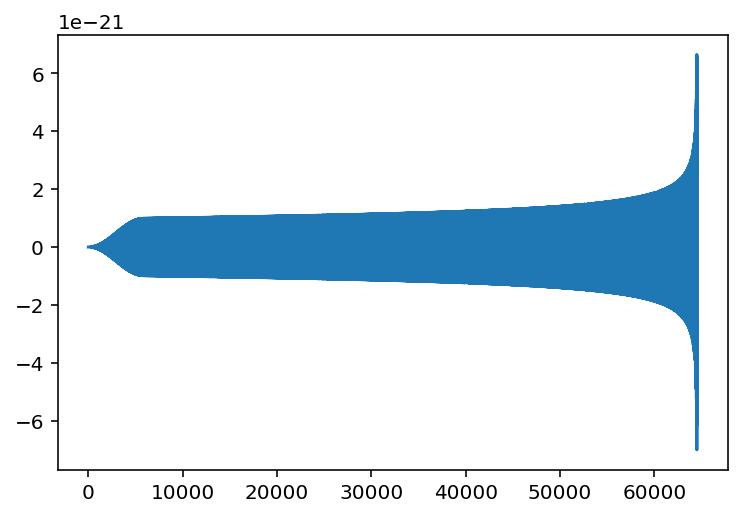

In [63]:
detector = Detector('H1')

geocent_end_time = 1187008882.4457 

# Define compact binary (component masses and distance)
mass1 = 1.4 # Msun 
mass2 = 1.4 # Msun 
distance = 1 # Mpc

# Define its geometrical parameters (sky position and other angles)
RA = 0
dec = 0
iota = 0
phi_ref = 0
psi = 0

# Define waveform model
approximant = "TaylorT4threePN"
amplitude_order = 0
phase_order = -1

# Define signal properties
sampling_rate = 1024 # Hz
segment_duration = 128 # s
freq_min = 30 # Hz
freq_max = sampling_rate/2.0

# Create binary            
binary = Binary(mass1, mass2, distance, ZERO, ZERO, \
                0.0, 0.0, 0, 0, iota, psi)

# Create waveform model
model = Template(approximant, amplitude_order, phase_order, sampling_rate,
                                    segment_duration, freq_min, freq_max, 0.0, phi_ref, None)

# Generate GW polarizations for that binary using that model
hplus, hcross = model.time_domain(binary)

# Project onto detector
hstrain = detector.project_strain(hplus, hcross, geocent_end_time, RA, dec, iota, psi)        

# Compute time delay wrt Earth center due to propagation
time_delay = detector.time_delay_from_earth_center(RA, dec, geocent_end_time)

# Time shift accordingly
hoft = numpy.roll(hstrain.data.data, int(time_delay * sampling_rate))

plot.plot(hoft)
plot.show()